#  K-Means Model File

## Import Packages

In [1]:
import sys
!{sys.executable} -m pip install nltk
!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install wordcloud

In [2]:
# Repeated from pre_processing.py

from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
nltk.download('stopwords') # <---------- ADDED IN
from nltk.corpus import stopwords
from train_wordvecs import tokenize
import pandas as pd
import numpy as np
import pickle
from train_wordvecs import load_data
from tqdm import tqdm

[nltk_data] Downloading package stopwords to /opt/conda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Slow version of gensim.models.doc2vec is being used
Slow version of Fasttext is being used


# Generate Features

In [3]:
# Import pickle file of tokenized text
re_tokened = pickle.load(open('re_tokenized_lemma.pkl', 'rb'))
re_tokened[:1]

[['manuscript',
  'evidence',
  'Austen',
  'continue',
  'work',
  'piece',
  'late',
  'period',
  '1809',
  "''",
  '11',
  'niece',
  'nephew',
  'Anna',
  'James',
  'Edward',
  'Austen',
  'make',
  'addition',
  'late',
  '1814']]

In [4]:
print('Length', len(re_tokened))

Length 416768


# K-Means Model

In [5]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
df = pd.read_csv('WikiLarge_Train.csv')
df.head(5)

,original_text,label
0,There is manuscript evidence that Austen conti...,1
1,"In a remarkable comparative analysis , Mandaea...",1
2,"Before Persephone was released to Hermes , who...",1
3,Cogeneration plants are commonly found in dist...,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...",1


#### Implement TfidfVectorizer

In [7]:
# Test Feature Representation: Pass full text to vectorizer
# This approach produced poorer results and was abandoned
original_text = df['original_text']
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
X = vectorizer.fit_transform(original_text)
# X_dense = X.toarray()

In [8]:
# Pass cleaned tokens to vectorizer
joined_token_list = []
for each_list in re_tokened:
    token_sentence = " ".join(each_list)
    joined_token_list.append(token_sentence)
original_text = joined_token_list
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2)) # max_features= 1000, # keep top 1000 terms , max_df = 0.5, 
X = vectorizer.fit_transform(original_text)
X.shape

(416768, 1630864)

In [9]:
# print(X)

In [10]:
# Create K-Means Model

def km_model(n_clusters, X):
    kmeans = KMeans(n_clusters = n_clusters, init='k-means++', max_iter=10, #100 originally
            n_init=1, random_state=42)
    kmeans_model = kmeans.fit(X)
    return kmeans_model

## K-Means Silhouette Scores and Sum Squared Errors

In [ ]:
# Combined SSE and Silhouette Score, plus plot
# Inspired by:
# https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion#:~:text=The%20idea%20behind%20elbow%20method,for%20each%20value%20of%20k.
# https://github.com/ashishsalunkhe/Topic-Modeling-using-LDA-and-K-Means-Clustering/blob/master/kmeans-cluster-and-topic-modeling.ipynb

from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

range_n_clusters = [100, 2]
elbow = []
ss = []

# Iterating through cluster sizes
for n_clusters in range_n_clusters:
    kmeans_model = km_model(n_clusters, X)

    #Finding the average silhouette score
    label = kmeans_model.labels_
    silhouette_avg = silhouette_score(X, label, metric='euclidean')
    ss.append(silhouette_avg)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", silhouette_avg)

    #Finding the average SSE"
    sse_average = kmeans_model.inertia_
    elbow.append(sse_average) # Inertia: Sum of distances of samples to their closest cluster center
    print("For n_clusters =", n_clusters,"The average SSE is :", sse_average)


In [ ]:
# Plot Elbow method of SSE and Silhouette Scores
# to determine optimal cluster number

fig = plt.figure(figsize=(14,7))
fig.add_subplot(121)
plt.plot(range_n_clusters, elbow,'b-',label='Sum of squared error')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.legend()

fig.add_subplot(122)
plt.plot(range_n_clusters, ss,'b-',label='Silhouette Score')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")
plt.legend()
plt.show()

In [ ]:
plt.plot(range_n_clusters, ss,'b-',label='Silhouette Score')

In [ ]:
plt.plot(range_n_clusters, elbow,'b-',label='Sum of squared error')

## K-Means Top Terms in Clusters

In [40]:
# Print out top terms from clusters
# (inspired by SIADS 543 HW Solution Approach)

n_clusters = 10
kmeans_model = km_model(n_clusters, X)
labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_

# Sort values and return list of terms
sort = np.argsort(-centers, axis=1)
terms_list = np.array(vectorizer.get_feature_names())
top_n = 10 # How many terms to keep
sorted_terms = terms_list[sort][:,:top_n]

results = []
for n in range(0,n_clusters):
    #<dynamically create key> 
    key = 'topic_'+str(n)
    #<calculate value> 
    value = sorted_terms[n,:].tolist()
    results.append([key,value]) 
# print(results)

In [41]:
for each in results:
    print(each[0], ": ", each[1])  

topic_0 :  ['american', 'album', 'band', 'bear', 'rock', 'release', 'singer', 'rock band', 'actor', 'know']
topic_1 :  ['city', 'county', 'capital', 'province', 'locate', 'state', 'municipality', 'district', 'large', 'large city']
topic_2 :  ['use', 'reference', 'year', 'make', 'know', 'website', 'people', 'new', 'work', 'rrb']
topic_3 :  ['time', 'world', 'number', 'war', 'championship', 'world war', 'wrestling', 'war ii', 'ii', 'career']
topic_4 :  ['football', 'football player', 'player', 'bear', 'japanese football', 'japanese', 'national football', 'national', 'team', 'play']
topic_5 :  ['commune', 'south', 'france', 'north', 'department', 'east', 'west', 'alpes', 'southern', 'america']
topic_6 :  ['department', 'france', 'region', 'commune', 'pas', 'calais', 'pas calais', 'aisne', 'north france', 'aisne department']
topic_7 :  ['united states', 'states', 'united', 'city', 'county', 'iowa united', 'iowa', 'city iowa', 'kentucky united', 'kentucky']
topic_8 :  ['play', 'team', 'leag

## K-Means Word Clouds

Cluster: 0


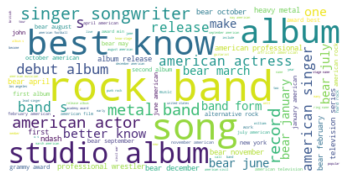

Cluster: 1


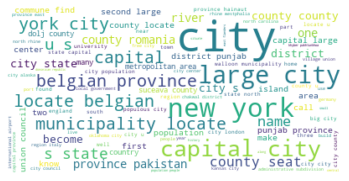

Cluster: 2


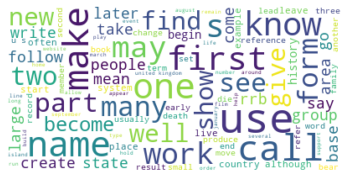

Cluster: 3


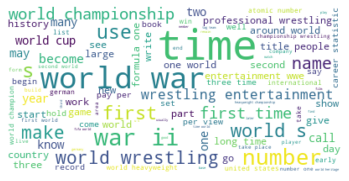

Cluster: 4


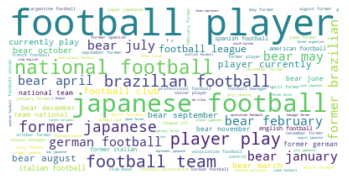

Cluster: 5


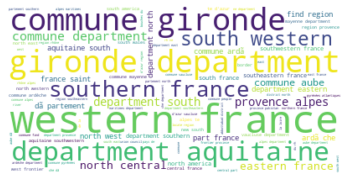

Cluster: 6


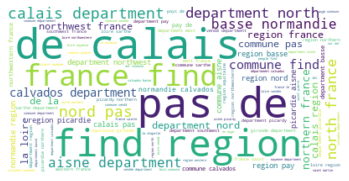

Cluster: 7


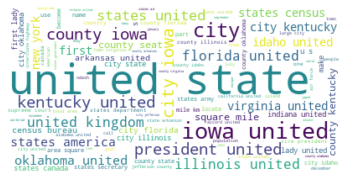

Cluster: 8


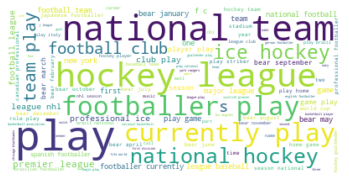

Cluster: 9


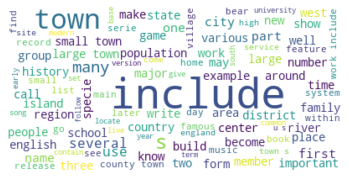

In [28]:
# Generate Word Clouds
# (inspired by https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d)

import matplotlib.pyplot as plt
from wordcloud import WordCloud

n_clusters = 10
kmeans_model = km_model(n_clusters, X)
labels = kmeans_model.labels_

result = {'cluster':labels, 'article_text':original_text} #result = {'cluster':labels,'wiki':wiki_lst}
result = pd.DataFrame(result)
for k in range(0,n_clusters):
    s = result[result.cluster==k]
    text = s['article_text'].str.cat(sep=' ')
    text = text.lower()
    text = ' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    print('Cluster: {}'.format(k))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()